In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import importlib as il

import itertools as it
import random
import warnings

from scipy import optimize
from addict import Addict

import ipydex

%load_ext ipydex.displaytools
%matplotlib inline

In [2]:
import stage_2a_bar_selection as bs
il.reload(bs)

from stage_2a_bar_selection import (
    load_img,
    rgb,
    get_bbox_list,
    assign_row_col,
    index_combinations,
    find_missing_boxes,
    handle_missing_boxes,
    select_bar_from_file,
    Attr_Array,
    rotate_img,
    CavityCarrierImageAnalyzier,

)


img_dir = "/home/ck/mnt/XAI-DIA-gl/Carsten/bilder_jpg2a/cropped/chunk000_stage1_completed/C0"
img_fpath = f"{img_dir}/2023-06-26_06-17-52_C50.jpg"

vv = {"vmin": 0, "vmax": 255}

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

<module 'stage_2a_bar_selection' from '/home/ck/iee-ge/XAI-DIA/image_classification/stage2/stage_2a_bar_selection.py'>

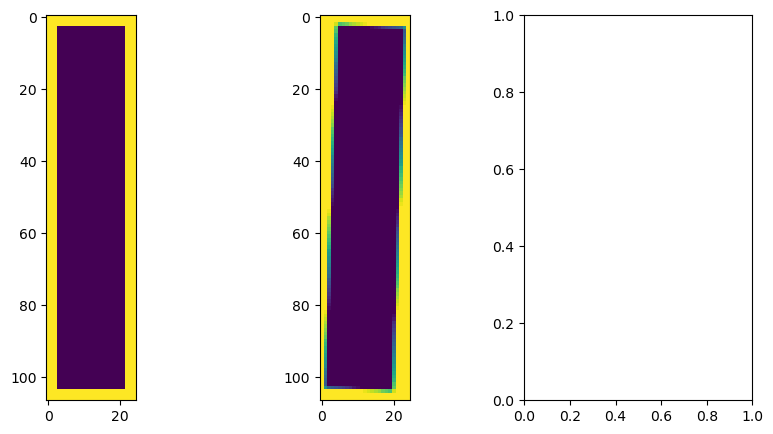

In [4]:
# test rect
test_img = np.ones((107, 25))*255
e = 3
test_img[e:-e , e:-e] = 65

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5));
ax1.imshow(test_img)

test_img2 = bs.rotate_img(test_img, -2)
ax2.imshow(test_img2)

plt.sca(ax3)

params = []



In [5]:
# Attempt to deploy the method of image moments to determine orientation
# http://raphael.candelier.fr/?blog=Image%20Moments&page=1#comments

$\bar{x} = \frac{M_{1,0}}{M_{0,0}}$, $\bar{y} = \frac{M_{0,1}}{M_{0,0}}$


$\mu_{2,0}' = \frac{M_{2,0}}{M_{0,0}} - \bar{x}^2$

$\mu_{1,1}' = \frac{M_{1,1}}{M_{0,0}} - \bar{x}\bar{y}$

$\mu_{0,2}' = \frac{M_{0,2}}{M_{0,0}} - \bar{y}^2$

$\theta = \frac{1}{2}.tan^{-1} \left( \frac{2\mu_{1,1}'}{\mu_{2,0}'-\mu_{0,2}'} \right)$

In [6]:
# this is now part of the bs module
def get_angle_from_moments(img):

    M = Addict(cv2.moments(img))

    X = M.m10 / M.m00
    Y = M.m01 / M.m00

    MU20 = M.m20 / M.m00 - X**2
    MU11 = M.m11 / M.m00 - X*Y
    MU02 = M.m02 / M.m00 - Y**2

    theta = 0.5 * np.arctan(2*MU11 / (MU20 - MU02)) * 180/np.pi
    return theta

CPU times: user 138 ms, sys: 1.25 ms, total: 140 ms
Wall time: 168 ms


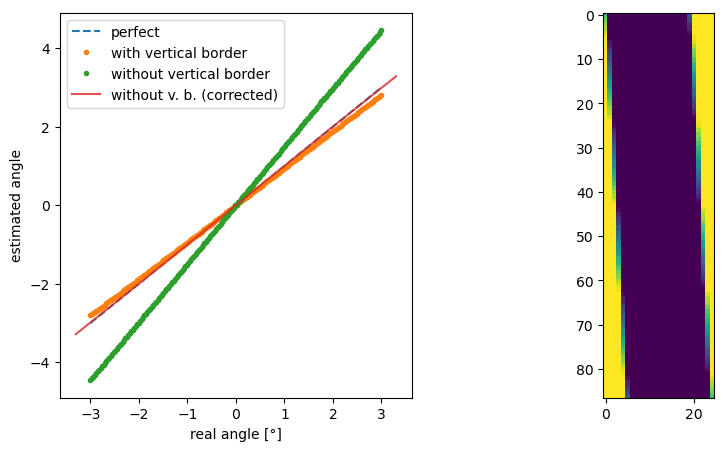

In [7]:
%%time


pp = []
pp2 = []
angles = np.linspace(-3, 3, 200)

for angle in angles:
    
    test_img2 = bs.rotate_img(test_img, angle)
    p = get_angle_from_moments(test_img2[:])
    pp.append(p)
    
    # vertical cutoff
    vc = 10
    pp2.append(get_angle_from_moments(test_img2[vc:-vc]))
    
pp = np.array(pp)
pp2 = np.array(pp2) 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5));
plt.sca(ax1)

plt.plot(angles, angles, "--", label="perfect")
plt.plot(angles, pp, ".", label="with vertical border")
plt.plot(angles, pp2, ".", label="without vertical border")
plt.plot(angles*1.1, 1.1*pp2*.67, "-", label="without v. b. (corrected)", alpha=0.8)
plt.xlabel("real angle [°]")
plt.ylabel("estimated angle")
plt.legend()
ax2.imshow(test_img2[vc:-vc])

### Interim summary

- Method of moments is fast and seems reliable (on artificial images)
- if the vertical border is missing a linear correction is necessary



back to chocolate bars

In [18]:
il.reload(bs)

<module 'stage_2a_bar_selection' from '/home/ck/iee-ge/XAI-DIA/image_classification/stage2/stage_2a_bar_selection.py'>

In [19]:
ccia = bs.CavityCarrierImageAnalyzier(img_fpath)

cell = ccia.get_raw_cell("a", "4", 3, 3)

[[51 34 35]
 [56 32 34]
 [67 32 33]]


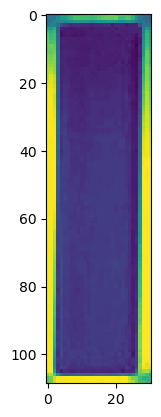

In [20]:
plt.imshow(cell)

In [21]:
%%time
get_angle_from_moments(cell)

CPU times: user 623 µs, sys: 154 µs, total: 777 µs
Wall time: 629 µs


-0.8767322438844154

In [22]:
%%time
bs.get_angle_from_hough(cell)

CPU times: user 0 ns, sys: 9.72 ms, total: 9.72 ms
Wall time: 23.9 ms


0.6499999999999798

## Systematic evaluation on real data

In [23]:
def draw_frame(ax, cell, e, f):
    
    y1, x1, y2, x2 = corners = np.r_[0, 0, cell.shape] + np.r_[e, f, -e, -f]
        
    ax.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], color="tab:red")
    

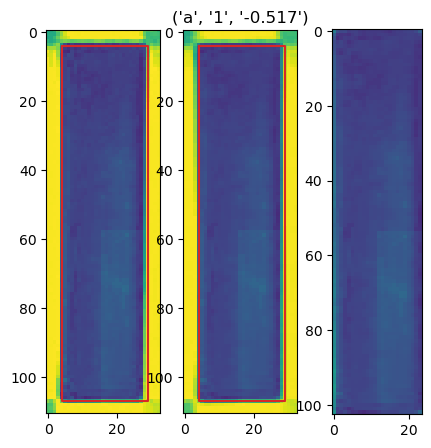

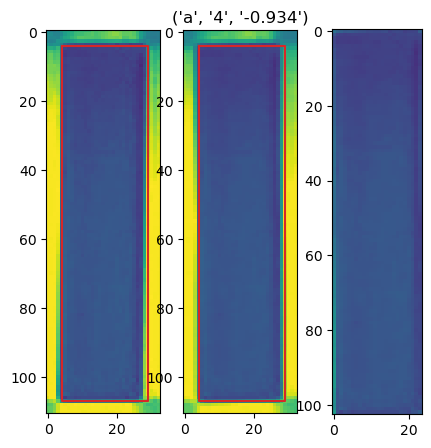

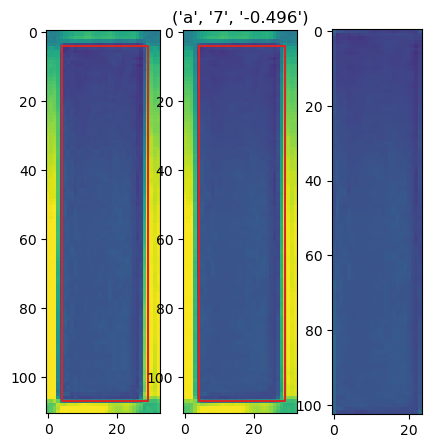

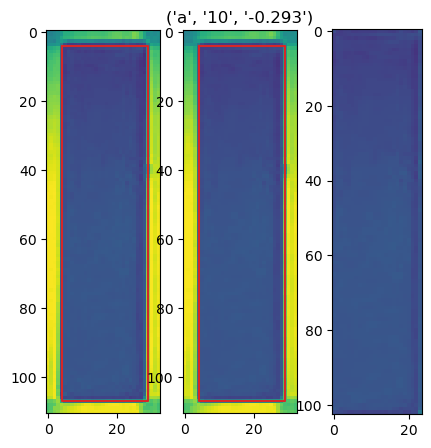

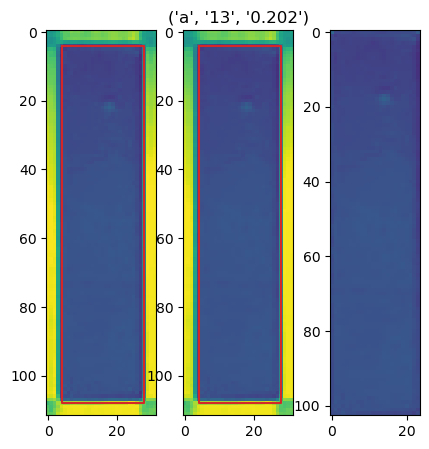

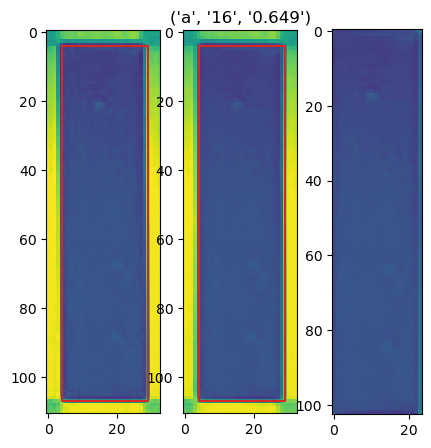

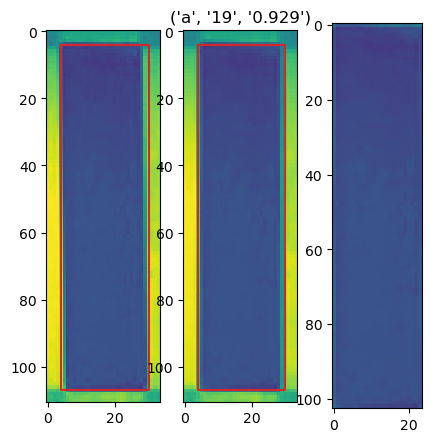

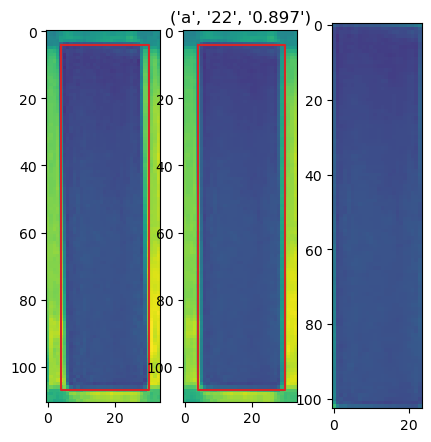

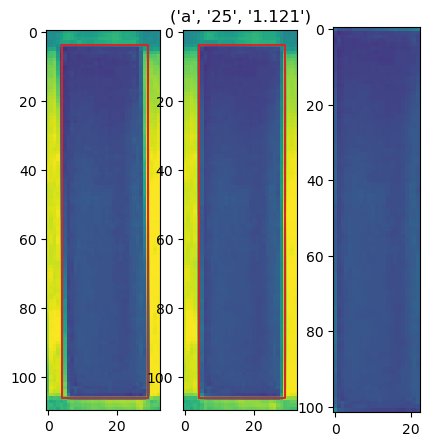

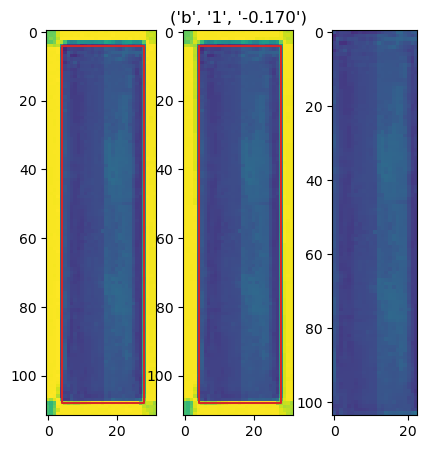

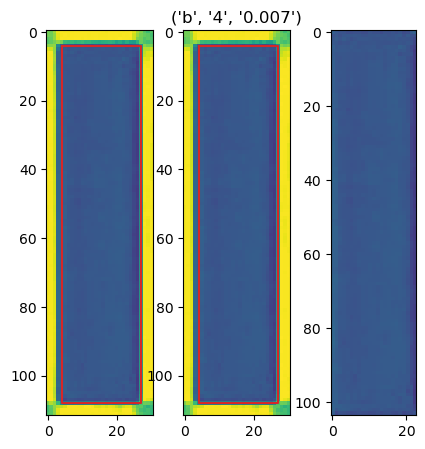

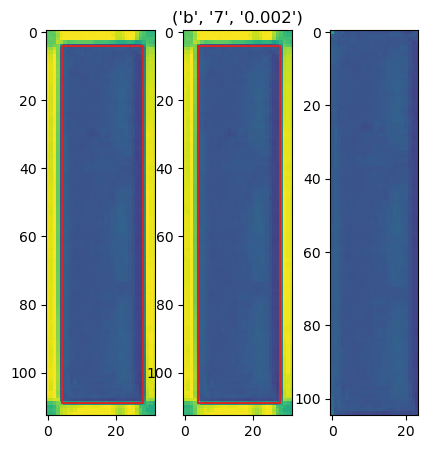

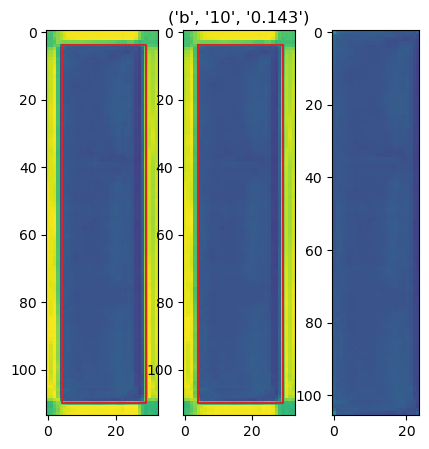

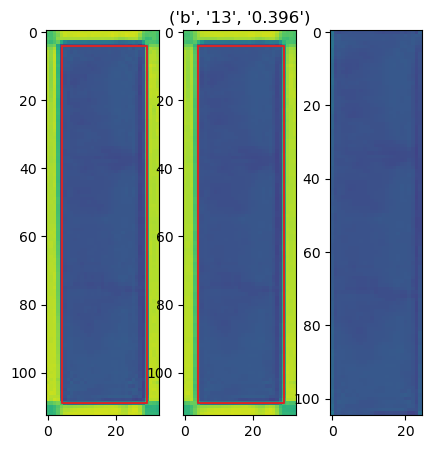

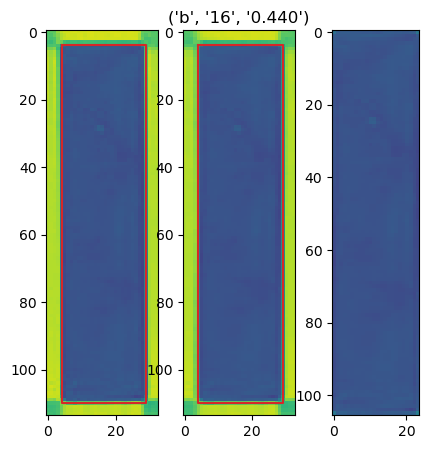

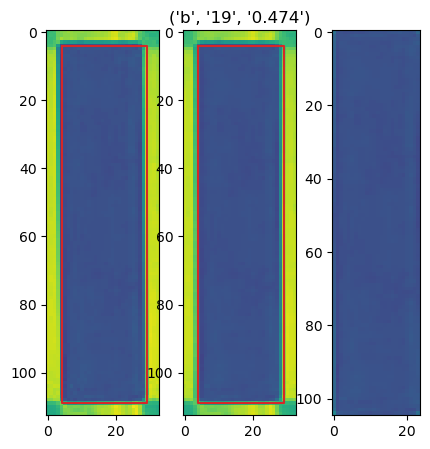

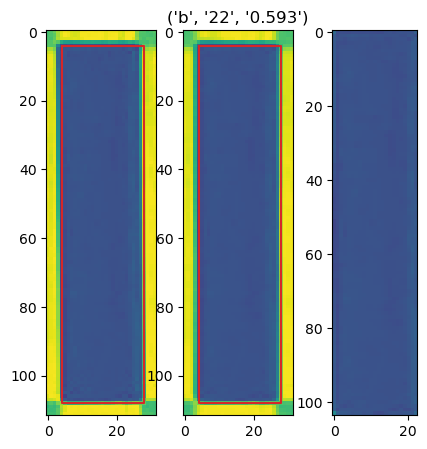

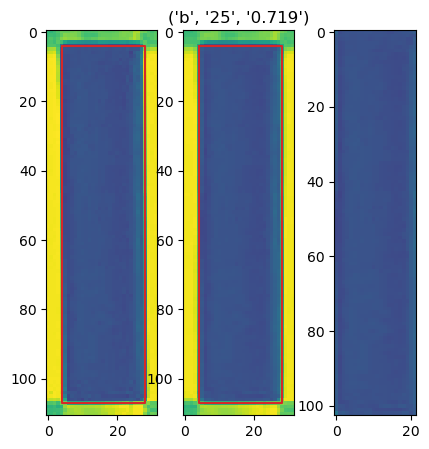

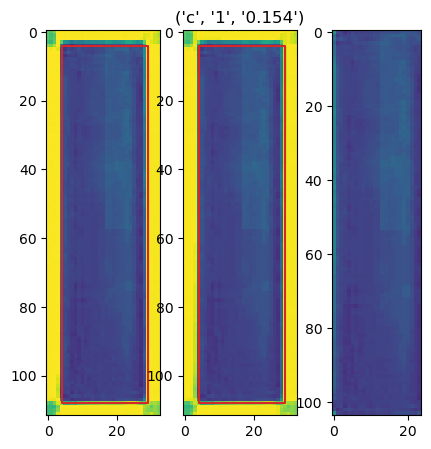

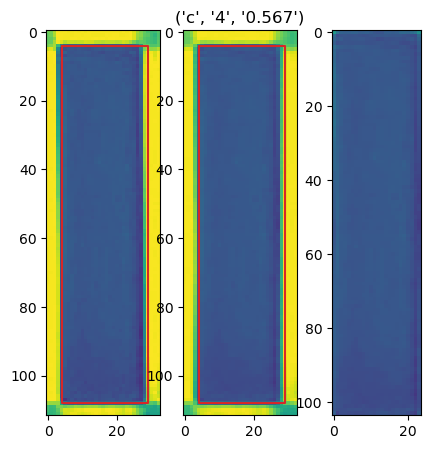

In [46]:
il.reload(bs)
cell_tups = bs.cell_tups

abbrev = False
dc = ipydex.Container()

ccia = bs.CavityCarrierImageAnalyzier(img_fpath)
for row, col in cell_tups[::3][:20]:
    
    if abbrev:
        row, col = "a 1".split()
    s = 5

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(s, s));

    e = 4
    f = 4
    cell1 = ccia.get_raw_cell(row, col, e, f)
    cell2 = ccia.get_corrected_cell(row, col, e, f, cut_to_bb=False, dc=dc)
    cell3 = ccia.get_corrected_cell(row, col, e, f)

    ax1.imshow(cell1, **vv)
    draw_frame(ax1, cell1, e, f)
    ax2.imshow(cell2, **vv)
    draw_frame(ax2, cell1, e, f)
    ax2.set_title(str((row, col, f"{dc.angle:05.3f}")))
    ax3.imshow(cell3, **vv)
    if abbrev:
        break

## Interim Summary

Angle correction seems to work.

However, bounding box might have to be redefined, to avoid bright border-column etc.



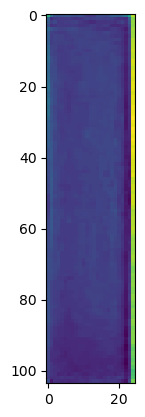

In [30]:
cell = ccia.get_corrected_cell("c", "4", e, f, dc=dc)
plt.imshow(cell[e:-e, f:-f])

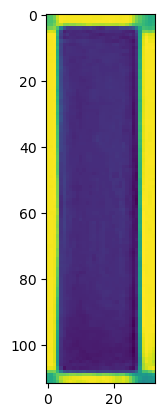

In [31]:
plt.imshow(cell)

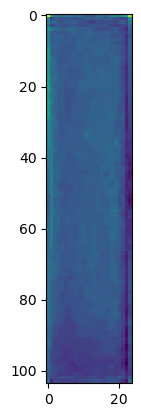

In [41]:
il.reload(bs)
ccia = bs.CavityCarrierImageAnalyzier(img_fpath)
cell = ccia.get_corrected_cell("c", "4", e, f, dc=dc)
x, y, w, h = bs.get_bbox_list(cell)[0][:4]

cell2 = cell[y:y+h, x:x+w]
plt.imshow(cell2)
